<a href="https://colab.research.google.com/github/mt-cs/statistics-of-ai/blob/main/AI_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print("Colab is ready")


Colab is ready


In [2]:
!pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl size=2554983 sha256=2c1071344dc5f1690ef9599eae312be4621148cd44c04e5ed755058d6cd3994e
  Stored in directory: /root/.cache/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise


In [1]:
!pip install numpy==1.26.4


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split


# 1. Understanding Recommendation Systems

Recommendation systems aim to predict which **items** (e.g., movies) a **user** will like based on past behavior.

## Collaborative Filtering (this project)
Collaborative filtering uses **user–item interactions** (ratings) to make recommendations.

- **User-based CF:** recommend items liked by *similar users*.
- **Item-based CF:** recommend items similar to what the user already liked.

**Key assumption:** if users agreed in the past, they are likely to agree in the future.

## Content-Based Filtering (contrast)
Content-based filtering recommends items based on **item attributes** (genre, cast, keywords) and a user’s profile.
It does **not** require other users’ ratings, but it depends on having reliable item metadata.

In this notebook, we build a collaborative filtering baseline using **matrix factorization (SVD)**.

In [3]:
# Load MovieLens 100k dataset from Surprise
data = Dataset.load_builtin('ml-100k')

# Confirm dataset loaded
print("MovieLens 100k dataset loaded successfully")


Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k
MovieLens 100k dataset loaded successfully


In [4]:
raw_ratings = data.raw_ratings

df = pd.DataFrame(raw_ratings, columns=['user_id', 'item_id', 'rating', 'timestamp'])
df = df.drop(columns=['timestamp'])

df.head()


,user_id,item_id,rating
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0


# 2. Data Exploration and Preprocessing

We inspect the dataset, check for missing values and duplicates, and visualize rating behavior
(e.g., rating distribution, ratings per user, ratings per movie). These steps help identify sparsity
and potential biases that can affect recommendation quality.


In [5]:
df.shape


(100000, 3)

In [6]:
df.isnull().sum()


,0
user_id,0
item_id,0
rating,0


In [7]:
df.duplicated().sum()


0

In [8]:
df = df.drop_duplicates()
df = df.dropna()

df.shape


(100000, 3)

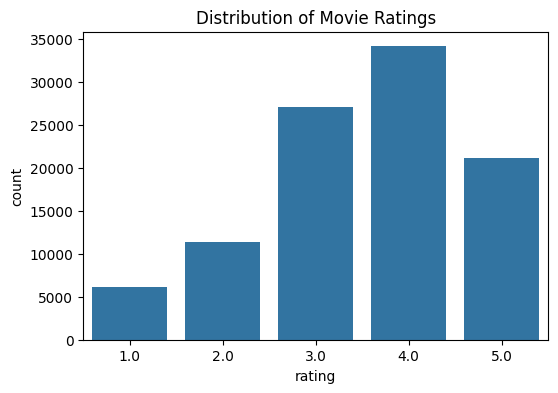

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=df)
plt.title("Distribution of Movie Ratings")
plt.show()


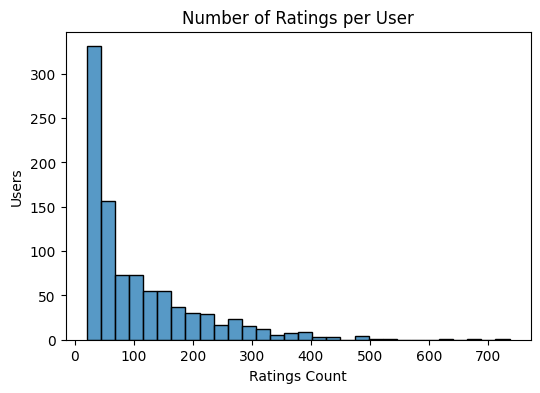

In [10]:
ratings_per_user = df.groupby('user_id')['rating'].count()

plt.figure(figsize=(6,4))
sns.histplot(ratings_per_user, bins=30)
plt.title("Number of Ratings per User")
plt.xlabel("Ratings Count")
plt.ylabel("Users")
plt.show()


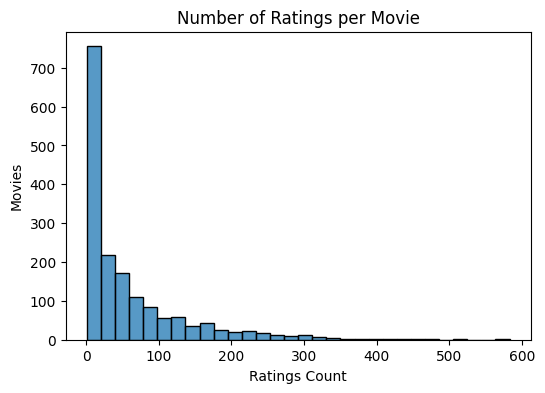

In [11]:
ratings_per_movie = df.groupby('item_id')['rating'].count()

plt.figure(figsize=(6,4))
sns.histplot(ratings_per_movie, bins=30)
plt.title("Number of Ratings per Movie")
plt.xlabel("Ratings Count")
plt.ylabel("Movies")
plt.show()


In [12]:
# Define rating scale
reader = Reader(rating_scale=(1, 5))

# Load data into Surprise format
data_surprise = Dataset.load_from_df(
    df[['user_id', 'item_id', 'rating']],
    reader
)


# 3. Data Splitting

We split the dataset into **training** and **testing** sets. The model learns from the training set and is evaluated on the test set.


In [13]:
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data_surprise, test_size=0.25, random_state=42)

print("Train-test split completed")


Train-test split completed


# 4. Model Selection: SVD Collaborative Filtering

We start with **SVD (Singular Value Decomposition)**, a matrix factorization method that learns latent user and item factors.
This is a strong baseline for rating prediction tasks.


In [14]:
model = SVD()
model.fit(trainset)

print("SVD model trained successfully")


SVD model trained successfully


# 5. Model Evaluation (RMSE)

We evaluate rating prediction accuracy using **Root Mean Squared Error (RMSE)**.
Lower RMSE indicates predicted ratings are closer to true user ratings.

In [15]:
predictions = model.test(testset)

rmse = accuracy.rmse(predictions)
print("RMSE:", rmse)


RMSE: 0.9419
RMSE: 0.9418568303084863


# 6. Hyperparameter Tuning (Grid Search)

We tune SVD hyperparameters such as:
- `n_factors`: number of latent factors
- `n_epochs`: training iterations
- `lr_all`: learning rate
- `reg_all`: regularization strength

We use cross-validation (`cv=3`) and optimize for **RMSE**.


In [17]:
from surprise.model_selection import GridSearchCV

param_grid = {
    'n_factors': [50, 100],
    'n_epochs': [20, 40],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.1]
}

grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
grid_search.fit(data_surprise)

print("Best RMSE score:", grid_search.best_score['rmse'])
print("Best params:", grid_search.best_params['rmse'])

Best RMSE score: 0.9277333283446675
Best params: {'n_factors': 100, 'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.1}
